<a href="https://colab.research.google.com/github/KokiNiimura/study/blob/master/DataLoader_pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/My Drive/study/PyTorch_Advanced/04

/content/drive/My Drive/study/PyTorch_Advanced/04


In [2]:
import json
import os
import os.path as osp
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data

In [3]:
def make_datapath_list(rootpath):

    json_path = osp.join(rootpath, 'COCO.json')
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this['root']

    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples):
        if data_json[count]['isValidation'] != 0.:
            val_indexes.append(count)
        else:
            train_indexes.append(count)

    train_img_list = list()
    val_img_list = list()

    for idx in train_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        train_img_list.append(img_path)

    for idx in val_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        val_img_list.append(img_path)

    train_mask_list = []
    val_mask_list = []

    for idx in train_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "./data/mask/train2014/mask_COCO_tarin2014_" + img_idx+'.jpg'
        train_mask_list.append(anno_path)

    for idx in val_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "./data/mask/val2014/mask_COCO_val2014_" + img_idx+'.jpg'
        val_mask_list.append(anno_path)

    train_meta_list = list()
    val_meta_list = list()

    for idx in train_indexes:
        train_meta_list.append(data_json[idx])

    for idx in val_indexes:
        val_meta_list.append(data_json[idx])

    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list

In [4]:
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
    rootpath="./data/")

val_meta_list[24]

{'annolist_index': 18.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'bbox_other': [[112.24, 245.32, 127.0, 110.76],
  [34.67, 208.02, 91.24, 152.36]],
 'dataset': 'COCO_val',
 'image_id': 488.0,
 'img_height': 406.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'isValidation': 1.0,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [127.0, 311.0, 1.0],
   [170.0, 307.0, 1.0],
   [180.0, 310.0, 1.0],
   [140.0, 341.0, 1.0],
   [148.0, 346.0, 1.0]],
  [[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [106.0, 227.0, 1.0],
   [92.0, 232.0, 1.0],
   [101.0, 232.0, 1.0],
   [0.0, 0.0, 2.0],
   [97.0, 257.0, 1.0],
   [0.0, 0.0, 2.0],
   [94.0, 282.0, 1.0],
   [55.0, 270.0, 1.0],
   [65.0, 271.0, 1.0

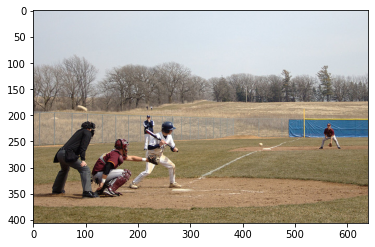

In [5]:
index = 24

img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [6]:
val_mask_list[index]

'./data/mask/val2014/mask_COCO_val2014_000000000488.jpg'

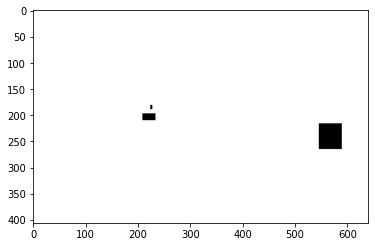

In [7]:
mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

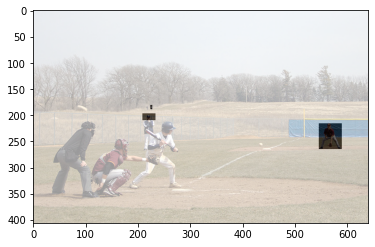

In [8]:
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

In [9]:
from utils.data_augumentation import Compose, get_anno, add_neck, aug_scale, aug_rotate, aug_croppad, aug_flip, remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor

class DataTransform():

    def __init__(self):
        self.data_transform = {
            'train': Compose([
                get_anno(),
                add_neck(),
                aug_scale(),
                aug_rotate(), 
                aug_croppad(),
                aug_flip(),
                remove_illegal_joint(),
                no_Normalize_Tensor()
            ]),
            'val': Compose([
            ])
        }

    def __call__(self, phase, meta_data, img, mask_miss):
        meta_data, img, mask_miss = self.data_transform[phase](
            meta_data, img, mask_miss)
        
        return meta_data, img, mask_miss

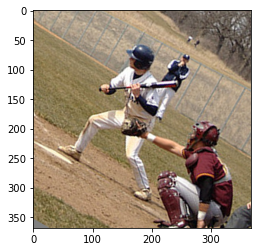

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


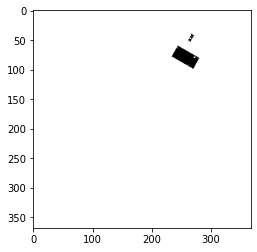

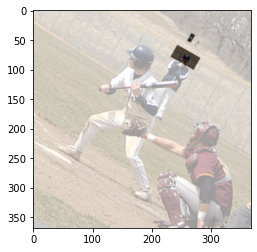

In [10]:
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

transform = DataTransform()
meta_data, img, mask_miss = transform("train", meta_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()

mask_miss = mask_miss.numpy().transpose((1, 2, 0))
plt.imshow(mask_miss)
plt.show()

img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert('RGB'))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

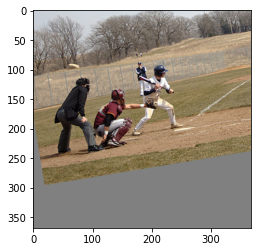

In [11]:
from utils.dataloader import get_ground_truth

index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

meta_data, img, mask_miss = transform("train", meta_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

plt.imshow(img)
plt.show()

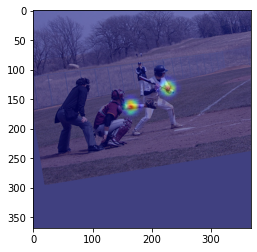

In [12]:
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

heat_map = heatmaps[:, :, 6]
heat_map = Image.fromarray(np.uint8(cm.jet(np.asarray(heat_map))*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

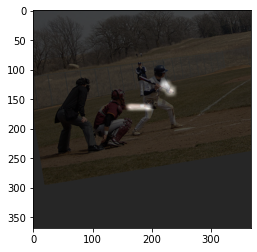

In [13]:
paf = pafs[:, :, 24]

paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

blend_img = cv2.addWeighted(img, 0.3, paf, 0.7, 0)
plt.imshow(blend_img)
plt.show()

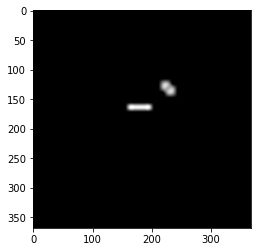

In [14]:
paf = pafs[:, :, 24]
paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.imshow(paf)

In [15]:
from utils.dataloader import get_ground_truth

class COCOkeypointsDataset(data.Dataset):
    def __init__(self, img_list, mask_list, meta_list, phase, transform):
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase
        self.transform = transform
    
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask
    
    def pull_item(self, index):
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)

        mask_miss = cv2.imread(self.mask_list[index])
        meta_data = self.meta_list[index]

        meta_data, img, mask_miss = self.transform(
            self.phase, meta_data, img, mask_miss)

        mask_miss_numpy = mask_miss.numpy().transpose((1, 2, 0))
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(
            meta_data, mask_miss_numpy)
        
        heat_mask = heat_mask[:, :, :, 0]
        paf_mask = paf_mask[:, :, :, 0]

        paf_mask = paf_mask.permute(2, 0, 1)
        heat_mask = heat_mask.permute(2, 0, 1)
        pafs = pafs.permute(2, 0, 1)
        heatmaps = heatmaps.permute(2, 0, 1)

        return img, heatmaps, heat_mask, pafs, paf_mask

In [16]:
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())
val_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())

item = train_dataset.__getitem__(0)
print(item[0].shape)
print(item[1].shape)
print(item[2].shape)
print(item[3].shape)
print(item[4].shape)

torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


In [17]:
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(dataloaders_dict["train"])
item = next(batch_iterator)
print(item[0].shape)
print(item[1].shape)
print(item[2].shape)
print(item[3].shape)
print(item[4].shape)

torch.Size([8, 3, 368, 368])
torch.Size([8, 19, 46, 46])
torch.Size([8, 19, 46, 46])
torch.Size([8, 38, 46, 46])
torch.Size([8, 38, 46, 46])
